<a id='StartingPoint'></a>
# ONNX classification example

Sharing DL models between frameworks or programming languages is possible with Open Neural Network Exchange (ONNX for short).

This notebook starts from an onnx model exported from MATLAB and uses it in Python.
On MATLAB a GoogleNet model pre-trained on ImageNet was loaded and saved to onnx file format through a one-line command [exportONNXNetwork(net,filename)](https://www.mathworks.com/help/deeplearning/ref/exportonnxnetwork.html).

The model is then loaded here, as well as the data to evaluate (some images retrieved from google).
Images are preprocessed to the desired format np.array with shape (BatchSize, numChannels, width, heigh), and the model is applied to classify the images and get the probabilities of the classifications.

## Input Variables

The why for the existence of each variable is explained [bellow](#ModelDef), near the model definition.

In [1]:
%%time
# model vars
modelPath  = 'D:/onnxStartingCode/model/preTrainedImageNetGooglenet.onnx'
labelsPath = 'D:/onnxStartingCode/model/labels.csv'
hasHeader  = 1

#data vars
image_folder = 'D:/onnxStartingCode/ImageFolder/'
EXT = ("jfif","jpg")

Wall time: 0 ns


## Import Modules

Let's start by importing all the needed modules

[back to top](#StartingPoint)

In [2]:
%%time
import onnx
import numpy as np
from PIL import Image
import os as os
import matplotlib.pyplot as plt
from onnxruntime import InferenceSession
import csv

Wall time: 416 ms


<a id='ModelDef'></a>
## Define Model and Data functions

We need to define functions to retrieve the Classifier and Data array.

To load the model we need the path to the file that stores it and the pat to the file that stores the labels. Finnaly, the parameter hasHeader defines the way the firs row of the labelsFile is treated, as header or ar a label.
The labelsPath is required here becuase the model here used does not contain label information, so an external csv file needs to be read.

[back to top](#StartingPoint)

In [3]:
%%time
def loadmodel(modelPath,labelsPath,hasHeader):

    # define network
    # load and check the model
    # load the inference module
    onnx.checker.check_model(modelPath)
    sess = InferenceSession(modelPath)
    
    # Determine the name of the input and output layers
    inname = [input.name for input in sess.get_inputs()]
    outname = [output.name for output in sess.get_outputs()]
    
    
    # auxiliary function to load labels file
    def extractLabels( filename , hasHeader ):
        file = open(filename)
        csvreader = csv.reader(file)
        if (hasHeader>0):
            header = next(csvreader)
            #print(header)

        rows = []
        for row in csvreader:
            rows.append(row)
        #print(rows)
        file.close()
        return rows
    
    
    # Get labels
    labels = extractLabels(labelsPath,hasHeader)


    # Extract information on the inputSize =(width, heigh) and numChannels = 3(RGB) or 1(Grayscale)  
    for inp in sess.get_inputs():
        inputSize = inp.shape
        
    numChannels = inputSize[1]
    inputSize = inputSize[2:4]
    
    return sess,inname,outname,numChannels,inputSize,labels


def getData(image_folder,EXT,inputSize):
    
    def getImagesFromFolder(EXT):
        imageList = os.listdir(image_folder)
        if (not(isinstance(EXT, list)) and not(isinstance(EXT,tuple))):
            ext = [EXT]

        fullFilePath = [os.path.join(image_folder, f) 
                        for ext in EXT for f in imageList if os.path.isfile(os.path.join(image_folder, f)) & f.endswith(ext)]

        return fullFilePath

    def imFile2npArray(imFile,inputSize):
        data = np.array([
            np.array(
                Image.open(fname).resize(inputSize),
                dtype=np.int64) 
            for fname in fullFilePath
        ])

        X=data.transpose(0,3,1,2)
        X = X.astype(np.float32)
        return X, data
    
    fullFilePath = getImagesFromFolder(EXT)
    X, data = imFile2npArray(fullFilePath,inputSize)
    
    
    return X,data,fullFilePath



Wall time: 0 ns


## Run loading functions to get model and data

* get full filename of all files in a gives directory that end with a given ext (might be an array of EXTENSIONS)
* load data into numpy arrays for future use:
    * to plot data has to have shape = (x,y,3)
    * the model here presented requires data with shape (3,x,y)
    * two data arrays are then exported, data for ploting and X for classification
    
[back to top](#StartingPoint)

In [4]:
%%time
# run code
sess,inname,outname,numChannels,inputSize,labels = loadmodel(modelPath,labelsPath,hasHeader)
X,data,fullFilePath = getData(image_folder,EXT,inputSize)


print("inputSize:   " + str(inputSize))
print("numChannels: " + str(numChannels))
print("inputName:  ", inname[0])
print("outputName: ", outname[0])

ValidationError: Unable to open model file:D:/onnxStartingCode/preTrainedImageNetGooglenet.onnx. Please check if it is a valid file.

## Define a functions to load all data

1. get full filename of all files in a gives directory that end with a given ext (might be an arrat of EXT)
2. load data into numpy arrays for future use:
    * to plot data has to have shape = (x,y,3)
    * the model here presented requires data with shape (3,x,y)
    * two data arrays are then exported, data for ploting and X for classification

[back to top](#StartingPoint)

## Classification

[back to top](#StartingPoint)

In [ ]:
%%time
#data_output = sess.run(outname, {inname: X[0]})
out = sess.run(None, {inname[0]: X})
out=np.asarray(out[0])

print(out.shape)

IND = []
PROB= []
for i in range(out.shape[0]):
    ind=np.where(out[i] == np.amax(out[i]))
    IND.append(ind[0][0])
    PROB.append(out[i,ind[0][0]])

l = [labels[ind] for ind in IND]
print([labels[ind] for ind in IND])
print(IND)
print(PROB)


(5, 1000)
[['tabby'], ['pug'], ['daisy'], ['tank'], ['tabby']]
[281, 254, 985, 847, 281]
[0.45442542, 0.96363264, 0.99984944, 0.6701486, 0.27902907]
Wall time: 87.9 ms


## Plot some examples

[back to top](#StartingPoint)

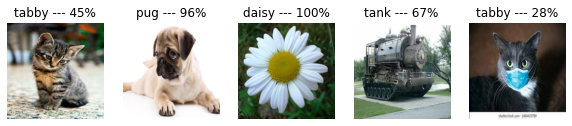

Wall time: 232 ms


In [ ]:
%%time
plt.figure(figsize=(10,10))
if data.shape[0]>=6:
    nPlots=6
    subArray=[2,3]
else:
    nPlots=data.shape[0]
    subArray = [1, nPlots]
    
for i in range(nPlots):
    plt.subplot(subArray[0],subArray[1],i+1)
    plt.imshow(data[i])
    plt.axis('off')
    plt.title(l[i][0] + ' --- ' + str(round(100*PROB[i])) + '%')
    
plt.show()


In [ ]:
[back to top](#StartingPoint)